In [ ]:
%matplotlib inline

3D geometries are load from a single Collada file:
    
```json
        "SceneGraph": {
        "Path": "input_data/error_phantom.dae",
        "Unit": "mm",
```

and each sample has its own material properties

```json
        "Samples": [
            {
                "Label": "Trachea",
                "Material": ["Mixture", [
                        1, 0.105,
                        6, 0.256,
                        7, 0.027,
                        8, 0.602,
                        11, 0.001,
                        15, 0.002,
                        16, 0.003,
                        17, 0.002,
                        19, 0.002
                    ]
                ],
                "Density": 1.030
            },

            {
                "Label": "Thymus",
                "Material": ["Mixture", [
                        1, 0.105,
                        6, 0.256,
                        7, 0.027,
                        8, 0.602,
                        11, 0.001,
                        15, 0.002,
                        16, 0.003,
                        17, 0.002,
                        19, 0.002
                    ]
                ],
                "Density": 1.030
            },
```

The sample labels in the JSON file corresponds to the same labels in the Collada file.

In [1]:
from ipywidgets import interact
import ipywidgets as widgets

import numpy as np # Who does not use Numpy?
import matplotlib # To plot images
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table

font = {'family' : 'serif',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from tifffile import imsave # Write TIFF files

import gvxrPython3 as gvxr # Simulate X-ray images
import json2gvxr # Set the X-ray simulation environment

SimpleGVXR 1.0.1 (2022-04-06T14:29:26) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2022-04-06T14:29:05) [Compiler: GNU g++] on Linux


We added `import json2gvxr` to the list of modules.

# Create an OpenGL context

To create an OpenGL context, the renderer is either "OPENGL" or "EGL". 
OPENGL is used to create an interactive visualisation window; EGL is used for offline rendering only, e.g. on a supercomputer.

In [2]:
json2gvxr.initGVXR("configuration-04.json", renderer="OPENGL")

Create an OpenGL context: 800x450


# Set up a monochromatic source

In [3]:
json2gvxr.initSourceGeometry()
spectrum, unit, k, f = json2gvxr.initSpectrum()

Set up the beam
	Source position: [0.0, 0.0, -1000.0, 'mm']
	Source shape: PointSource


# Set up an ideal detector

In [4]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, 0.0, 150.0, 'mm']
	Detector up vector: [0, -1, 0]
	Detector number of pixels: [1152, 1152]
	Pixel spacing: [0.4340277777777778, 0.4340277777777778, 'mm']


# Load the sample data

In [5]:
json2gvxr.initSamples(verbose=1)

Load the 3D data

Load the 3D objects from a scenegraph (input_data/error_phantom.dae)
0 Trachea
1 Thymus
2 Stomach-Interior
3 Stomach
4 Spleen
5 Small-Intestine
6 Skull
7 Pancreas
8 Muscle
9 Lung-right
10 Lung-left
11 Liver
12 Large-Intestine
13 Kidneys-right
14 Kidneys-left
15 Heart
16 Gallbladder
17 Eyes-right
18 Eyes-left
19 Cartilage
20 Brain
21 Bone
22 Bladder


# Compute an X-ray image

We convert the array in a Numpy structure and store the data using single-precision floating-point numbers.

In [6]:
print("Compute an X-ray image");
x_ray_image = np.flip(gvxr.computeXRayImage(), 1).astype(np.single)

Compute an X-ray image


# Flat-field correction

In [7]:
total_energy_in_MeV = gvxr.getTotalEnergyWithDetectorResponse()

In [8]:
white = np.ones(x_ray_image.shape) * total_energy_in_MeV
dark = np.zeros(x_ray_image.shape)

x_ray_image_flat = (x_ray_image - dark) / (white - dark)

# Save the X-ray image in a TIFF file

In [9]:
imsave('output_data/raw_x-ray_image-04.tif', x_ray_image)
imsave('output_data/flat_x-ray_image-04.tif', x_ray_image_flat)

# Display the X-ray image

In [10]:
gamma = 3.5

vmin = x_ray_image_flat.min()
vmax = x_ray_image_flat.max()

def interact_plot():

    fig_plot = plt.figure(figsize= (20,10))

    ax = plt.subplot(131)
    plt.imshow(x_ray_image_flat, cmap="gray")
    plt.colorbar(orientation='horizontal')
    ax.set_title("Using a linear colour scale")

    plt.suptitle("Image simulated using gVirtualXray", y=0.95)
    ax = plt.subplot(132)
    plt.imshow(x_ray_image_flat, norm=LogNorm(vmin=vmin, vmax=vmax), cmap="gray")
    plt.colorbar(orientation='horizontal')
    ax.set_title("Using a logarithmic colour scale")

    ax_img = plt.subplot(133)
    plt.imshow(x_ray_image_flat, norm=PowerNorm(gamma=1./gamma), cmap="gray")
    plt.colorbar(orientation='horizontal')
    ax_img.set_title("Using a Power-law colour scale\n(gamma:" + str(gamma) + ")")

    plt.tight_layout()
    plt.close()

    # Callback function
    def update_plot(gamma):
        ax_img.imshow(x_ray_image_flat, norm=PowerNorm(gamma=1./gamma), cmap="gray")
        ax_img.set_title("Using a Power-law colour scale\n(gamma: " + str(gamma) + ")")
        display(fig_plot)

    interact(update_plot,
             gamma=widgets.FloatSlider(value=gamma, min=0.01, max=10.0, step=0.05, description="gamma"))

interact_plot();

interactive(children=(FloatSlider(value=3.5, description='gamma', max=10.0, min=0.01, step=0.05), Output()), _…

# Update the visualisation window

In [11]:
gvxr.displayScene()

# Interactive visualisation

The user can rotate the 3D scene and zoom-in and -out in the visualisation window.

- Keys are:
    - Q/Escape: to quit the event loop (does not close the window)
    - B: display/hide the X-ray beam
    - W: display the polygon meshes in solid or wireframe
    - N: display the X-ray image in negative or positive
    - H: display/hide the X-ray detector
- Mouse interactions:
    - Zoom in/out: mouse wheel
    - Rotation: Right mouse button down + move cursor

In [12]:
gvxr.renderLoop()

# Take a screenshot

This image can be used in a research paper to illustrate the simulation environment, in which case you may want to change the background colour to white with:

In [13]:
gvxr.setWindowBackGroundColour(1.0, 1.0, 1.0)

or dark-grey

In [14]:
gvxr.setWindowBackGroundColour(0.25, 0.25, 0.25)

and update the visualisation window

In [15]:
gvxr.displayScene()

take the screenshot and save it in a file

In [16]:
screenshot = gvxr.takeScreenshot()

In [17]:
plt.imsave("output_data/screenshot-04.png", np.array(screenshot))

display it using Matplotlib

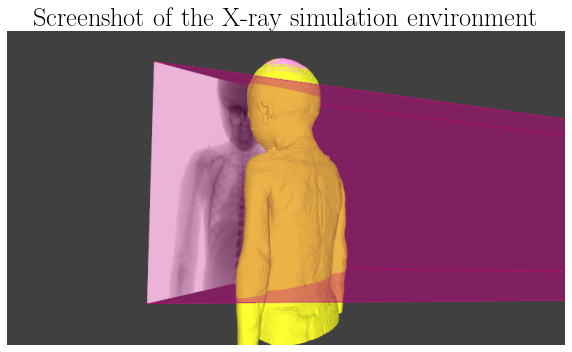

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(screenshot)
plt.title("Screenshot of the X-ray simulation environment")
plt.axis('off');

## All done

Destroy the window

In [19]:
gvxr.destroyAllWindows()